In [1]:
import tensorflow as tf

In [2]:
from collections import namedtuple, OrderedDict
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K

In [29]:
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

In [3]:
tf.compat.v1.disable_eager_execution()

In [5]:
#构建输入层
#将输入的数据转换成字典的形式，定义输入层的时候让输入层的name和字典中特征的key一致，就可以使得输入的数据和对应的Input层对应

In [4]:
def build_input_layers(feature_columns):
    input_layer_dict = {}
    
    for fc in feature_columns:
        if isinstance(fc, SparseFeat):
            input_layer_dict[fc.name] = Input(shape=(1,), name=fc.name)
        elif isinstance(fc, DenseFeat):
            input_layer_dict[fc.name] = Input(shape=(fc.dimension,), name=fc.name)
        elif isinstance(fc, VarLenSparseFeat):
            input_layer_dict[fc.name] = Input(shape=(fc.maxlen,), name=fc.name)
            
            if fc.length_name:
                input_layer_dict[fc.length_name] = Input((1,), name=fc.length_name, dtype='int32')
        else:
            input_layer_dict[fc] = Input((1,), name=fc, dtype='int32')
    return input_layer_dict



In [5]:
#构建embedding层
def build_embedding_layers(feature_columns, input_layer_dict):
    embedding_layer_dict = {}
    
    for fc in feature_columns:
        if isinstance(fc, SparseFeat):
            embedding_layer_dict[fc.name] = Embedding(fc.vocabulary_size, fc.embedding_dim, name='emb_'+fc.name)
        elif isinstance(fc, VarLenSparseFeat):
            embedding_layer_dict[fc.name] = Embedding(fc.vocabulary_size + 1, fc.embedding_dim, name='emb_'+fc.name, mask_zero=True)
    return embedding_layer_dict

def embedding_lookup(feature_columns, input_layer_dict, embedding_layer_dict):
    embedding_list = []
    for fc in feature_columns:
        _input = input_layer_dict[fc]
        _embed = embedding_layer_dict[fc]
        embed = _embed(_input)
        embedding_list.append(embed)
    return embedding_list

In [6]:
#输入层拼接成列表
def concat_input_list(input_list):
    feature_nums = len(input_list)
    
    if feature_nums > 1:
        return Concatenate(axis=1)(input_list)
    elif feature_nums == 1:
        return input_list[0]
    else:
        return None

In [7]:
#将所有的sparse特征embedding拼接
def concat_embedding_list(feature_columns, input_layer_dict, embedding_layer_dict, flatten=False):
    embedding_list = []
    for fc in feature_columns:
        _input = input_layer_dict[fc.name] #获取输入层
        _embed = embedding_layer_dict[fc.name] #B*1*dim 获取对应的embedding层
        embed = _embed(_input) #B*dim 将Input层输入到embedding层中
        
        #是否需要flatten,如果embedding列表最终是直接输入到Dense层中，需要进行Flatten,否则不需要
        if flatten:
            embed = Flatten()(embed)
        embedding_list.append(embed)
    return embedding_list

In [8]:
"""Attention Network"""
class Dice(Layer):
    def __init__(self):
        super(Dice, self).__init__()
        self.bn = BatchNormalization(center=False, scale=False)
    
    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(input_shape[-1],), dtype=tf.float32, name='alpha')
    def call(self, x):
        x_normed = self.bn(x)
        x_p = tf.sigmoid(x_normed)
        
        return self.alpha * (1.0-x_p) * x + x_p * x

class LocalActivationUnit(Layer):
    def __init__(self, hidden_units=(256, 128, 64), activation='prelu'):
        super(LocalActivationUnit, self).__init__()
        self.hidden_units = hidden_units
        self.linear = Dense(1)
        self.dnn = [Dense(unit, activation=PReLU() if activation=='prelu' else Dice()) for unit in hidden_units]
    def call(self, inputs):
        #query:B*1*embed_dim  keys:B*len*emb_dim
        query, keys = inputs
        
        #获取序列长度
        keys_len, keys_dim = keys.get_shape()[1], keys.get_shape()[2]
        
        queries = tf.tile(query, multiples=[1, keys_len, 1]) #(None, lem*emb_dim)
        queries = tf.reshape(queries, shape=[-1, keys_len, keys_dim])
        
        #将特征进行拼接
        att_input = tf.concat([queries, keys, queries-keys, queries*keys], axis=-1) #B*len*4*emb_dim
        
        #将原始向量与外积结果拼接后输入到一个dnn中
        att_out = att_input
        for fc in self.dnn:
            att_out = fc(att_out) #B*len*att_out
        att_out = self.linear(att_out) #B*len*1
        att_out = tf.squeeze(att_out, -1) #B*len
        return att_out
class AttentionPoolingLayer(Layer):
    def __init__(self, user_behavior_length, att_hidden_units=(256, 128, 64), return_score=False):
        super(AttentionPoolingLayer, self).__init__()
        self.att_hidden_units = att_hidden_units
        self.local_att = LocalActivationUnit(self.att_hidden_units)
        self.user_behavior_length = user_behavior_length
        self.return_score = return_score
    
    def call(self, inputs):
        #keys:B*len*emb_dim, queries:B*1*emb_dim
        queries, keys = inputs
        #获取行为序列embedding的mask矩阵，将Embedding矩阵中的非零元素设置为True
        key_masks = tf.sequence_mask(self.user_behavior_length, keys.shape[1]) #(None, 1, max_len) 这里注意user_behavior_length是(None,1)
        key_masks = key_masks[:, 0, :] #所以上面会多出1个维度来，这里去掉才行，(None, max_len)
        
        #获取行为序列中每个商品对应的注意力权重
        attention_score = self.local_att([queries, keys]) #(None, max_len)
        
        #创建一个padding的tensor, 目的是为了标记出行为序列embedding中无效的位置
        paddings = tf.zeros_like(attention_score) #B*len
        
        #outputs 表示的是padding之后的attention_score
        outputs = tf.where(key_masks, attention_score, paddings) #B*len
        
        #将注意力分数与序列对应位置加权求和，这一步可以在
        outputs = tf.expand_dims(outputs, axis=1) #B*1*len
        
        if not self.return_score:
            #keys:B*len*emb_dim
            outputs = tf.matmul(outputs, keys)#B*1*dim
            outputs = tf.squeeze(outputs, axis=1)
        return outputs

In [9]:
"""DNN Network"""
def get_dnn_logits(dnn_input, hidden_units=(200,80), activation='prelu'):
    dnns = [Dense(unit, activation=PReLU() if activation=='prelu' else Dice()) for unit in hidden_units]
    
    dnn_out = dnn_input
    for dnn in dnns:
        dnn_out = dnn(dnn_out)
    
    #获取logits
    dnn_logits = Dense(1, activation='sigmoid')(dnn_out)
    return dnn_logits

In [10]:
"""会话兴趣分割层"""
def get_embedding_vec_list(embedding_layer_dict, input_dict, sparse_feature_columns, return_feat_list):
    embedding_vec_list = []
    for fg in sparse_feature_columns:#['movie_id']
        feat_name = fg.name
        if feat_name in return_feat_list:
            embedding_vec_list.append(embedding_layer_dict[feat_name](input_dict[feat_name]))
    return embedding_vec_list
class BiasEncoding(Layer):
    """位置编码"""
    def __init__(self,sess_max_count, seed=1024):
        super(BiasEncoding, self).__init__()
        self.sess_max_count = sess_max_count
        self.seed = seed
    def build(self, input_shape):
        #在该层创建一个可训练的权重 input_shape [None, sess_max_count, max_seq_len, embed_dim]
        if self.sess_max_count == 1:
            embed_size = input_shape[2]
            seq_len_max = input_shape[1]
        else:
            embed_size = input_shape[0][2]
            seq_len_max = input_shape[0][1]
        #声明那三个位置偏置编码矩阵
        self.sess_bias_embedding = self.add_weight('sess_bias_encoding', shape=(self.sess_max_count, 1, 1), 
                                                  initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.0001, seed=self.seed)) #截断产生正态随机树
        self.seq_bias_embedding = self.add_weight('sess_bias_encoding', shape=(1, seq_len_max, 1),
                                                 initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.0001, seed=self.seed))
        self.embed_bias_embedding = self.add_weight('sess_bias_encoding', shape=(1, 1, embed_size),
                                                   initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.0001, seed=self.seed))
        super(BiasEncoding, self).build(input_shape)
    def call(self, inputs, mask=None):
        """
        inputs:A list 长度是会话数量，每个元素表示一个会话矩阵，维度是[None, max_seq_len, embed_dim]
        """
        bias_encoding_out = []
        for i in range(self.sess_max_count):
            bias_encoding_out.append(inputs[i] + self.embed_bias_embedding + self.seq_bias_embedding + self.sess_bias_embedding[i])
        return bias_encoding_out
def sess_interest_division(embedding_layer_dict, user_behavior_input_dict, sparse_feature_columns, sess_feature_columns, 
                          sess_max_count, bias_encoding=True):
    """
    会话分割层
    embedding_layer_dict:各个特征的embedding层
    user_behavior_input_dict:用户的会话特征构成的字典，
    sparse_feature_columns:筛选出来的离散特征名称
    sess_feature_columns:用户的会话行为'movie_id'
    sess_max_count:用户的会话数量
    bias_encoding:是否需要偏置编码
    
    return transformer的输入
    """
    tr_input = []
    for i in range(sess_max_count):
        sess_name = 'sess' + str(i+1)
        #获取每个会话里面各个物品的embedding向量
        keys_emb_list = get_embedding_vec_list(embedding_layer_dict, user_behavior_input_dict[sess_name],
                                              sparse_feature_columns, sess_feature_columns)
        keys_emb = concat_input_list(keys_emb_list)
        tr_input.append(keys_emb)
    #tr_input是个列表，每个元素代表一个会话，维度是[None, max_seq_len, embed_dim]
#     print("tr_input:::", len(tr_input), tr_input[0].shape)
    if bias_encoding:
        tr_input = BiasEncoding(sess_max_count)(tr_input)
    #这里返回了一个列表，里面的每个元素代表一个会话，维度是[None, max_seq_len, embed_dim]
    return tr_input

In [11]:
"""会话兴趣抽取层"""
#位置编码
def positional_encoding(inputs, pos_embedding_trainable=True, scale=True):
    """
    inputs:(None, max_seq_len, embed_dim)
    """
    _, T, num_units = inputs.get_shape().as_list() #[None, max_seq_len, embed_dim]
    position_ind = td.expand_dims(tf.range(T), 0) #[1, max_seq_len]
    
    #First part of the PE function:sin and argument
    position_enc = np.array([
        [pos / np.power(1000, 2. * i / num_units) for i in range(num_units)] for pos in range(T)
    ])
    
    #Second part, apply the cosine to even columns and sin to odds.
    position_enc[:, 0::2] = np.sin(position_enc[:, 0::2]) #dim 2i
    position_enc[:, 1::2] = np.cos(position_enc[:, 1::2]) #dim 2i+1
    
    #转成张量
    if pos_embedding_trainable:
        lookup_table = K.variable(position_enc, dtype=tf.float32)
    outputs = tf.nn.embedding_lookup(lookup_table, position_ind)
    if scale:
        outputs = outputs * num_units ** 0.5
    return outputs + inputs

class LayerNormalization(Layer):
    def __init__(self, axis=-1, eps=1e-9, center=True, scale=True):
        super(LayerNormalization, self).__init__()
        self.axis = axis
        self.eps = eps
        self.center = center
        self.scale = scale
    def build(self, input_shape):
        """
        input_shape:[None, max_seq_len, singlehead_emb_dim*head_num]
        """
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],#[1, max_seq_len, singlehead_emb_dim*head_num]
                                    initializer=tf.keras.initializers.Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                   initializer=tf.keras.initializers.Zeros(), trainable=True) #[1, max_seq_len, singlehead_emb_dim*head_num]
        super(LayerNormalization, self).build(input_shape)
    def call(self, inputs):
        """
        [None, max_seq_len, singlehead_emb_dim*head_num]
        """
        mean = K.mean(inputs, axis=self.axis, keepdims=True) #embed_dim维度上求均值
        variance = K.mean(K.square(inputs-mean), axis=-1, keepdims=True) #embed_dim维度求方差
        std = K.sqrt(variance + self.eps)
        outputs = (inputs - mean) / std
        
        if self.scale:
            outputs *= self.gamma
        if self.center:
            outputs += self.beta
        return outputs

class Transformer(Layer):
    """Transformer网络"""
    def __init__(self, singlehead_emb_size=1, att_head_nums=8, dropout_rate=0.0, use_positional_encoding=False, use_res=True,
                use_feed_forward=True, use_layer_norm=False, blinding=False, seed=1024):
        super(Transformer, self).__init__()
        self.singlehead_emb_size = singlehead_emb_size
        self.att_head_nums = att_head_nums
        self.num_units = self.singlehead_emb_size * self.att_head_nums
        self.use_res = use_res
        self.use_feed_forward = use_feed_forward
        self.dropout_rate = dropout_rate
        self.use_positional_encoding = use_positional_encoding
        self.use_layer_norm = use_layer_norm
        self.blinding = blinding  #如果为True的话表明进行attention的时候未来的units都被屏蔽，解码器的时候用
        self.seed = seed
    #这里需要为该层自定义可训练的参数矩阵  WQ,WK,WV
    def build(self, input_shape):
        #input_shape:[None, max_seq_len, embed_dim]
        embedding_size = int(input_shape[0][-1])
        print('transfomer_embedding_size:', embedding_size)
        #检查合法性
        if self.num_units != embedding_size:
            raise ValueError("att_embedding_size * head_num must equal the last dimension size of inputs, got %d * %d != %d" % (
            self.singlehead_emb_size,att_head_nums, embedding_size))
        self.seq_len_max = int(input_shape[0][-2])
        #定义三个矩阵
        self.W_Query = self.add_weight(name='query', shape=[embedding_size, self.singlehead_emb_size*self.att_head_nums],
                                      dtype=tf.float32, initializer=tf.keras.initializers.TruncatedNormal(seed=self.seed))
        self.W_Key = self.add_weight(name='key', shape=[embedding_size, self.singlehead_emb_size*self.att_head_nums],
                                    dtype=tf.float32, initializer=tf.keras.initializers.TruncatedNormal(seed=self.seed+1))
        self.W_Value = self.add_weight(name='value', shape=[embedding_size, self.singlehead_emb_size*self.att_head_nums],
                                      dtype=tf.float32, initializer=tf.keras.initializers.TruncatedNormal(seed=self.seed+2))
        #用神经网络的话，加两层训练参数
        if self.use_feed_forward:
            self.fw1 = self.add_weight('fw1', shape=[self.num_units, 4 * self.num_units], dtype=tf.float32,
                                      initializer=tf.keras.initializers.glorot_uniform(seed=self.seed))
            self.fw2 = self.add_weight('fw2', shape=[4*self.num_units, self.num_units], dtype=tf.float32,
                                      initializer=tf.keras.initializers.glorot_uniform(seed=self.seed+1))
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.ln = LayerNormalization()
        super(Transformer, self).build(input_shape)
    def call(self, inputs, mask=None, training=None):
        """
        inputs:[当前会话sessi, 当前会话sessi] 维度(None, max_seq_len, embed_dim)
        mask:当前会话mask, 这是个1维数组，维度是(None,), 表示每个样本在当前会话里面的行为序列长度
        """
        #q和k其实都是一样的矩阵
        queries, keys = inputs
        query_masks, key_masks = mask, mask
        
        #这里需要对Q和K进行mask操作
        #key masking目的是让key值的unit为0的key对应的attention score极小，这样加权计算value时相当于对结果不产生影响
        #Query Masking 要屏蔽的时被0所填充的内容
        query_masks = tf.sequence_mask(query_masks, self.seq_len_max, dtype=tf.float32) #(None, 1, seq_len_max)
        key_masks = tf.sequence_mask(key_masks, self.seq_len_max, dtype=tf.float32) #(None, 1, seq_len_max),注意key_masks开始是(None,1)
        key_masks = key_masks[:,0,:] #所以上面会多出个1维度来，这里去掉才行(None, seq_len_max)
        query_masks = query_masks[:,0,:] #同理
        
        #是否位置编码
        if self.use_positional_encoding:
            queries = positional_encoding(queries)
            keys = positional_encoding(queries)
        
        #tensordot是矩阵乘，好处是当两个矩阵维度不同的时候，只要指定axes也可以乘
        #这里表示的是queries的-1维度与W_Query的0维度相乘
        #(None, max_seq_len, embedding_size) *[embeding_size, singlehead_emb_size*head_num]
        querys = tf.tensordot(queries, self.W_Query, axes=(-1,0)) #[None, max_seq_len_q, singlehead_emb_size*head_num]
        
        keys = tf.tensordot(keys, self.W_Key, axes=(-1,0)) #[None, max_seq_len_k, singlehead_emb_size*head_num]
        values = tf.tensordot(keys, self.W_Value, axes=(-1,0)) #[None, max_seq_len_k, singlehead_emb_size*head_num]
        
        #tf.split切分张量，这里从头那里切分成head_num个张量，然后从0维拼接
        querys = tf.concat(tf.split(querys, self.att_head_nums, axis=2), axis=0) #[head_num*None, max_seq_len_q, singlehead_emb_size]
        keys = tf.concat(tf.split(keys, self.att_head_nums, axis=2), axis=0) #[head_num*None, max_seq_len_k, singlehead_emb_size]
        values = tf.concat(tf.split(values, self.att_head_nums, axis=2), axis=0) #[head_num*None, max_seq_len_k, singlehead_emb_size]
        
        #Q*K keys后两维转置然后再乘[head_num*None, max_seq_len_q, max_seq_len_k]
        outputs = tf.matmul(querys, keys, transpose_b=True)
        outputs = outputs / (keys.get_shape().as_list()[-1] ** 0.5)
        
        #从0维度上复制head_num次
        key_masks = tf.tile(key_masks, [self.att_head_nums, 1]) #[head_num*None, max_seq_len_k]
        key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, tf.shape(queries)[1], 1]) #[head_num*None, max_seq_len_q, max_seq_len_k]
        paddings = tf.ones_like(outputs) * (-2**32 + 1)
        
        outputs = tf.where(tf.equal(key_masks, 1), outputs, paddings) #被填充的部分赋予极小的权重
        
        #标识是否屏蔽未来序列的信息(解码器self attention 的时候不能看到自己之后的那些信息)
        #这里通过下三角矩阵的方式进行，依次表示预测第一个词，第二个词，第三个词。。。
        if self.blinding:
            diag_vals = tf.ones_like(outputs[0,:,:]) #[T_q, T_k]
            tril = tf.linalg.LinearOperatorLowerTriangular(diag_vals).to_dense() #(T_q, T_k) 这是个下三角矩阵
            masks = tf.tile(tf.expand_dims(tril, 0), [tf.shape(outputs)[0], 1, 1]) #(h*N, T_q, T_k)
            
            paddings = tf.ones_like(masks) * (-2 ** 32 + 1)
            outputs = tf.where(tf.equal(masks, 0), paddings, outputs) #(h*N, T_q, T_k)
        
        outputs -= tf.reduce_max(outputs, axis=-1, keepdims=True)
        outputs = tf.nn.softmax(outputs, axis=-1) #最后一个维度求softmax,换成权重
        
        query_masks = tf.tile(query_masks, [self.att_head_nums, 1]) #[head_num*None, max_seq_len_q]
        query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, tf.shape(keys)[1]]) #[head_num*None, max_seq_len_q, max_seq_len_k]
        
        outputs *= query_masks
        
        #权重矩阵过下dropot [head_num*None, max_seq_len_q, max_seq_len_k]
        outputs = self.dropout(outputs, training=training)
        
        #weighted sum [head_num*None, max_seq_len_q, max_seq_len_k] * #[head_num*None, max_seq_len_k, singlehead_emb_size]
        result = tf.matmul(outputs, values) #[head_num*None, max_seq_len_q, singlehead_emb_size]
        
        #换回去了
        result = tf.concat(tf.split(result, self.att_head_nums, axis=0), axis=2) #[None, max_seq_len_q, head_num*singlehead_emb_size]
        
        if self.use_res: #残差连接
            result += queries
        if self.use_layer_norm:
            result = self.ln(result)
        if self.use_feed_forward: #[None, max_seq_len_q, head_num*singlehead_emb_size]与[num_units, self.num_units]
            fw1 = tf.nn.relu(tf.tensordot(result, self.fw1, axes=[-1,0])) #[None, max_seq_len_q, 4*num_units]
            fw1 = self.dropout(fw1, training=training)
            fw2 = tf.tensordot(fw1, self.fw2, axes=[-1, 0]) #[None, max_seq_len_q, num_units] 这个num_units其实就等于head_num*singlehead_emb_size
            
            if self.use_res:
                result += fw2
            if self.use_layer_norm:
                result = self.ln(result)
        return tf.reduce_mean(result, axis=1, keepdims=True) #[None, 1, head_num*singleh]
def sess_interest_extractor(tr_input, sess_max_count, Transformer, mask):
    tr_out = []
    for i in range(sess_max_count):
        tr_out.append(Transformer([tr_input[i], tr_input[i]], mask[i])) #tr_input[i] (None, max_seq_len, embed_dim)
    #tr_out是个list, 里面每个元素维度(None, 1, embed_dim)，表示当前会话的综合兴趣，下面再T的这个维度上拼接
    sess_fea = concat_input_list(tr_out) #(None, sess_max_cout, embed_dim)
    return sess_fea

In [12]:
"""会话兴趣交互层"""
class BiLSTM(Layer):
    def __init__(self, units, layers=2, res_layers=0, dropout_rate=0.2, merge_mode='ave'):
        super(BiLSTM, self).__init__()
        self.units = units
        self.layers = layers
        self.res_layers = res_layers
        self.dropout_rate = dropout_rate
        self.merge_mode = merge_mode
    #这里要构建正向的LSTM和反向的LSTM，因为我们是要两者的计算结果最后相加，所以这里需要分别计算
    def build(self, input_shape):
        """
        input_shape:(None, sess_max_count, embed_dim)
        """
        self.fw_lstm = []
        self.bw_lstm = []
        for _ in range(self.layers):
            self.fw_lstm.append(LSTM(self.units, dropout=self.dropout_rate, bias_initializer='ones', return_sequences=True, unroll=True))
            #go_backwards 如果为真，则反向处理输入序列并返回相反的序列
            #unroll 布尔(默认错误)。如果为真，则网络将展开，否则使用符号循环。展开可以提高RNN的速度，尽管它往往会占用更多的内存。展开只适用于较短的序列
            self.bw_lstm.append(LSTM(self.units, dropout=self.dropout_rate, bias_initializer='ones', return_sequences=True, go_backwards=True, unroll=True))
            super(BiLSTM, self).build(input_shape)
    def call(self, inputs):
        input_fw = inputs
        input_bw = inputs
        for i in range(self.layers):
            output_fw = self.fw_lstm[i](input_fw)
            output_bw = self.bw_lstm[i](input_bw)
            output_bw = Lambda(lambda x:K.reverse(x, 1), mask=lambda inputs, mask:mask)(output_bw)
            
            if i >= self.layers - self.res_layers:
                output_fw += input_fw
                output_bw += input_bw
            input_fw = output_fw
            input_bw = output_bw
        if self.merge_mode == 'fw':
            output = output_fw
        elif self.merge_mode == 'bw':
            output = output_bw
        elif self.merge_mode == 'concat':
            output = K.concatenate([output_fw, output_bw])
        elif self.merge_mode == 'sum':
            output = output_fw + output_bw
        elif self.merge_mode == 'ave':
            output = (output_fw + output_bw) / 2
        elif self.merge_mode == 'mul':
            output = output_fw * output_bw
        elif self.merge_mode is None:
            output = [output_fw, output_bw]
        return output

In [13]:
"""DSIN Network"""
def DSIN(feature_columns, sess_feature_list, sess_max_count=5, bias_encoding=True, singlehead_emb_size=1,
        att_head_nums=8, dnn_hidden_units=(200, 80)):
    """
    建立DSIN网络
    feature_columns: a list,每个特征封装nametuple形式
    behavior_feature_list: a list 行为特名称
    sess_max_count:会话的个数
    bias_encoding:是否偏置编码
    singlehead_emb_size:每个头的注意力的维度，注意这个和头数的乘积必须等于输入的embedding的维度
    att_head_nums:头的个数
    dnn_hidden_units:这个是全连接网络的神经元个数
    """
    #检查下embedding设置的是否合法，因为这里有了多头注意力机制之后，我们要保证我们的embedding维度=att_head_nums * att_embedding_size
    hist_emb_size = sum(map(lambda fc:fc.embedding_dim, filter(lambda fc:fc.name in sess_feature_list, 
                                                               [feature for feature in feature_columns if not isinstance(feature, str)])))
    if singlehead_emb_size * att_head_nums != hist_emb_size:
        raise ValueError('hist_emb_size must equal to singlehead_emb_size * att_head_num, got %d != %d' % (
        hist_emb_size, singlehead_emb_size, att_head_nums))
    
    #建立输入层
    input_layer_dict = build_input_layers(feature_columns)
    #将Input层转化为列表的形式作为model的输入
    input_layers = list(input_layer_dict.values()) #各个输入层
    input_keys = list(input_layer_dict.keys()) #各个列名
    user_sess_seq_len = [input_layer_dict['seq_length'+str(i+1)] for i in range(sess_max_count)]
    user_sess_len = input_layer_dict['sess_length']
    
    #筛选出特征中的sparse_fea, dense_fea, varlen_fea
    sparse_feature_columns = list(filter(lambda x:isinstance(x, SparseFeat), feature_columns)) if feature_columns else []
    dense_feature_columns = list(filter(lambda x:isinstance(x, DenseFeat), feature_columns)) if feature_columns else []
    varlen_sparse_feature_columns = list(filter(lambda x:isinstance(x, VarLenSparseFeat), feature_columns)) if feature_columns else []
    
    #获取dense
    dnn_dense_input = []
    for fc in dense_feature_columns:
        dnn_dense_input.append(input_layer_dict[fc.name])
    #将所有的dense特征拼接
    dnn_dense_input = concat_input_list(dnn_dense_input)
    
    #构建embedding词典
    embedding_layer_dict = build_embedding_layers(feature_columns, input_layer_dict)
    
    #因为这里最终需要将embedding拼接后直接输入到全连接层(dense)中，所以需要Flatten
    dnn_sparse_embed_input = concat_embedding_list(sparse_feature_columns, input_layer_dict, embedding_layer_dict, flatten=True)
    #将所有sparse特征的embedding进行拼接
    dnn_sparse_input = concat_input_list(dnn_sparse_embed_input)
    #dnn_dense_input和dnn_sparse_input这样就不用管了，等待后面的拼接就完事了，下面只要是会话行为兴趣的提取
    
    #首先获取当前的行为特征(movie)的embedding,这里有可能有多个行为产生了行为序列，所以需要使用列表将其放在一起
    #这个东西最后求局域Attention的时候使用，也就是选择与当前候选物品最相关的会话兴趣
    query_embed_list = embedding_lookup(sess_feature_list, input_layer_dict, embedding_layer_dict)
    query_emb = concat_input_list(query_embed_list)
    
    #下面就是开始会话行为的处理了，四个层来：会话分割层，会话兴趣提取层，会话兴趣交互层和局部Attention层，下面一一来做
    
    #首先这里是找到会话行为中的特征列的输入层，其实用input_layer_dict也行
    user_behavior_input_dict = {}
    for idx in range(sess_max_count):
        sess_input = OrderedDict()
        for i, feat in enumerate(sess_feature_list):#我这里只有一个movie_id
            sess_input[feat] = input_layer_dict['sess'+str(idx+1)]
        user_behavior_input_dict['sess'+str(idx+1)] = sess_input #这里其实是获取那五个会话的输入层
    
    #会话兴趣分割层：拿到每个会话里面各个商品的embedding，并且进行偏置编码，得到transformer的输入
    transformer_input = sess_interest_division(embedding_layer_dict, user_behavior_input_dict, sparse_feature_columns, sess_feature_list,
                                              sess_max_count, bias_encoding=bias_encoding)
    #这个transformer_input是个列表，里面的每个元素代表一个会话，维度是(None, max_seq_len, embed_dim)
    
    #会话兴趣提取层：每个会话过transformer,从多个角度得到里面各个商品之间的相关性(交互)
    self_attention = Transformer(singlehead_emb_size, att_head_nums, dropout_rate=0,use_layer_norm=True,
                                use_positional_encoding=(not bias_encoding), blinding=False)
    sess_fea = sess_interest_extractor(transformer_input, sess_max_count, self_attention, user_sess_seq_len)
    #这里的输出sess_fea是个矩阵，维度(None, sess_max_count, embed_dim) 这个东西后期要和当前的候选商品求Attention进行sess维度上的加权
    
    #会话兴趣交互层 上面的transformer结果，过双向的LSTM
    lstm_output = BiLSTM(hist_emb_size, layers=2, res_layers=0, dropout_rate=0.2)(sess_fea)
    #这个lstm_output是个矩阵，维度是(None, sess_max_count, hidden_units_num)
    
    #会话兴趣激活层，这里就是计算两波注意力
    interest_attention = AttentionPoolingLayer(user_sess_len)([query_emb, sess_fea])
    lstm_attention = AttentionPoolingLayer(user_sess_len)([query_emb, lstm_output])
    #上面这两个的维度分别是(None, embed_size),(None, hidden_units_num) 这里embed_size=hidden_units_num
    
    #下面就是把dnn_dense_input, dnn_sparse_input, interest_attention, lstm_attention拼接起来
    deep_input = Concatenate(axis=-1)([dnn_dense_input, dnn_sparse_input, interest_attention, lstm_attention])
    
    #全连接网络，获得最终的dnn_logits
    dnn_logits = get_dnn_logits(deep_input, activation='prelu')
    
    model = Model(input_layers, dnn_logits)
    #所有变量需要初始化
    tf.compat.v1.keras.backend.get_session().run(tf.compat.v1.global_variables_initializer())
    
    return model

In [14]:
import pandas as pd
import numpy as np

In [15]:
samples_data = pd.read_csv('movie_sample.txt', sep='\t', header=None)
samples_data.columns = ['user_id', 'gender', 'age', 'hist_movie_id', 'hist_len', 'movie_id', 'movie_type_id', 'label']

#把历史行为序列转成整数列表
def str2list(x):
    return [int(i) for i in x.split(',')]
samples_data['hist_movie_id'] = samples_data['hist_movie_id'].apply(lambda x:str2list(x))

In [16]:
#会话处理
#把hist_movie_id拆成6个会话，每个会话的长度是10，会话不够的0填充
for i in range(5):
    samples_data['sess' + str(i+1)] = samples_data['hist_movie_id'].apply(lambda x:x[i*10:(i+1)*10])

#每个样本的会话个数，这里的hist_len其实就是sess_nums了
sess_nums = np.array([len([int(i) for i in l if int(i) != 0]) // 10 + 1 for l in samples_data['hist_movie_id']])
sess_nums = np.array([i if i <= 5 else 5 for i in sess_nums]) # 这个是正好50个行为的这种，按照上面那个算会是6，但其实5个会话
sess_max_count = 5
del samples_data['hist_movie_id']

In [17]:
samples_data.head(2).append(samples_data.tail(2))

,user_id,gender,age,hist_len,movie_id,movie_type_id,label,sess1,sess2,sess3,sess4,sess5
0,1,1,1,1,112,2,1,"[186, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,1,1,1,38,5,0,"[186, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1378,3,2,3,50,141,9,0,"[5, 207, 198, 147, 109, 82, 80, 57, 84, 200]","[88, 174, 193, 95, 183, 64, 162, 37, 28, 156]","[56, 135, 152, 38, 41, 130, 108, 23, 81, 105]","[137, 71, 86, 69, 68, 185, 169, 67, 11, 31]","[93, 92, 202, 83, 97, 126, 128, 197, 168, 32]"
1379,3,2,3,50,15,3,0,"[5, 207, 198, 147, 109, 82, 80, 57, 84, 200]","[88, 174, 193, 95, 183, 64, 162, 37, 28, 156]","[56, 135, 152, 38, 41, 130, 108, 23, 81, 105]","[137, 71, 86, 69, 68, 185, 169, 67, 11, 31]","[93, 92, 202, 83, 97, 126, 128, 197, 168, 32]"


In [18]:
X = samples_data.drop(columns='label')
y = samples_data['label']

#构建mask是个列表，每个元素代表每个session里面序列的mask
mask = []
for i in range(sess_max_count):
    mask.append(
        np.array([len([k for k in l if k!= 0]) for l in X['sess'+str(i+1)]])
    )

In [19]:
#mask的长度为5，每一个元素是一个数组，第i个元素保存了第i个session用户观看的电影数量
#每个元素是一个数组，数组长度是样本个数，也就是数组中的每个元素保存了每个样本在该sess下观看电影的数量，其实也就是每个样本在该session下的
#序列实际长度
len(mask), mask[0].shape, samples_data.shape

(5, (1380,), (1380, 12))

In [20]:
mask[0],mask[1], mask[2],mask[3],mask[4]

(array([ 1,  1,  1, ..., 10, 10, 10]),
 array([ 0,  0,  0, ..., 10, 10, 10]),
 array([ 0,  0,  0, ..., 10, 10, 10]),
 array([ 0,  0,  0, ..., 10, 10, 10]),
 array([ 0,  0,  0, ..., 10, 10, 10]))

In [22]:
sess_nums.shape,sess_nums[0]
#sess_nums 保存了每个样本实际上的session数量

((1380,), 1)

In [23]:
#构建DSIN模型的输入格式
X_train = {"user_id": np.array(X["user_id"]), \
        "gender": np.array(X["gender"]), \
        "age": np.array(X["age"]), \
        "movie_id": np.array(X["movie_id"]), \
        "movie_type_id": np.array(X["movie_type_id"]), \
        "hist_len": np.array(X["hist_len"]), \
        "sess1": np.stack(X['sess1']), \
        "sess2": np.stack(X['sess2']), \
        "sess3": np.stack(X['sess3']), \
        "sess4": np.stack(X['sess4']), \
        "sess5": np.stack(X['sess5']), \
        "seq_length1": mask[0], \
        "seq_length2": mask[1], \
        "seq_length3": mask[2], \
        "seq_length4": mask[3], \
        "seq_length5": mask[4], \
        "sess_length": sess_nums
        }

y_train = np.array(y)

In [24]:
from collections import namedtuple

#使用具名元组定义特征标记
SparseFeat = namedtuple('SparseFeat',['name', 'vocabulary_size', 'embedding_dim'])
DenseFeat = namedtuple('DenseFeat', ['name', 'dimension'])
VarLenSparseFeat = namedtuple('VarLenSparseFeat', ['name', 'vocabulary_size', 'embedding_dim', 'maxlen', 'length_name'])

In [25]:
"""特征封装"""

feature_columns = [SparseFeat('user_id', max(samples_data["user_id"])+1, embedding_dim=8), 
                    SparseFeat('gender', max(samples_data["gender"])+1, embedding_dim=8), 
                    SparseFeat('age', max(samples_data["age"])+1, embedding_dim=8), 
                    SparseFeat('movie_id', max(samples_data["movie_id"])+1, embedding_dim=8),
                    SparseFeat('movie_type_id', max(samples_data["movie_type_id"])+1, embedding_dim=8),
                    DenseFeat('hist_len', 1)]

feature_columns += [VarLenSparseFeat('sess1', vocabulary_size=max(samples_data["movie_id"])+1, embedding_dim=8, maxlen=10, length_name='seq_length1'),
                    VarLenSparseFeat('sess2', vocabulary_size=max(samples_data["movie_id"])+1, embedding_dim=8, maxlen=10, length_name='seq_length2'), 
                    VarLenSparseFeat('sess3', vocabulary_size=max(samples_data["movie_id"])+1, embedding_dim=8, maxlen=10, length_name='seq_length3'), 
                    VarLenSparseFeat('sess4', vocabulary_size=max(samples_data["movie_id"])+1, embedding_dim=8, maxlen=10, length_name='seq_length4'), 
                    VarLenSparseFeat('sess5', vocabulary_size=max(samples_data["movie_id"])+1, embedding_dim=8, maxlen=10, length_name='seq_length5'), 
                   ]
feature_columns += ['sess_length']

# 行为特征列表，表示的是基础特征
sess_feature_list = ['movie_id']

In [26]:
learning_rate = 0.001
batch_size = 64
epochs = 10

In [27]:
#构建DSIN模型
model = DSIN(feature_columns, sess_feature_list, bias_encoding=True)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
transfomer_embedding_size: 8
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
sess1 (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
sess2 (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
sess3 (InputLayer)              [(None, 10)]         0                             

In [30]:
#模型编译
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=learning_rate), metrics=[AUC()])

In [31]:
#模型训练
callbacks= [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), #早停
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.01, verbose=1) #调整学习率
]
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=batch_size, callbacks=callbacks)

Train on 1104 samples, validate on 276 samples
Epoch 1/10
1104/1104 [==============================] - 6s 6ms/sample - loss: 0.5819 - auc: 0.4744 - val_loss: 0.4786 - val_auc: 0.4998
Epoch 2/10
1104/1104 [==============================] - 1s 783us/sample - loss: 0.4767 - auc: 0.4988 - val_loss: 0.5148 - val_auc: 0.4931
Epoch 3/10
1104/1104 [==============================] - 1s 747us/sample - loss: 0.5163 - auc: 0.5043 - val_loss: 0.4738 - val_auc: 0.4908
Epoch 4/10
1104/1104 [==============================] - 1s 736us/sample - loss: 0.4936 - auc: 0.5050 - val_loss: 0.4787 - val_auc: 0.4751
Epoch 5/10
1104/1104 [==============================] - 1s 722us/sample - loss: 0.4765 - auc: 0.5011 - val_loss: 0.4863 - val_auc: 0.4422
Epoch 6/10
1024/1104 [==========================>...] - ETA: 0s - loss: 0.4523 - auc: 0.5155
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1104/1104 [==============================] - 1s 1ms/sample - loss: 0.4568 - auc: 0.5168 - v

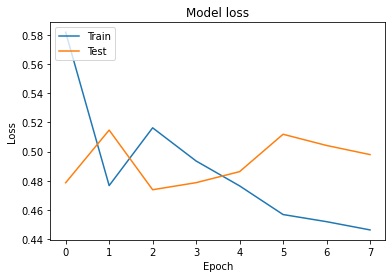

In [33]:
"""可视化下看看训练情况"""
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

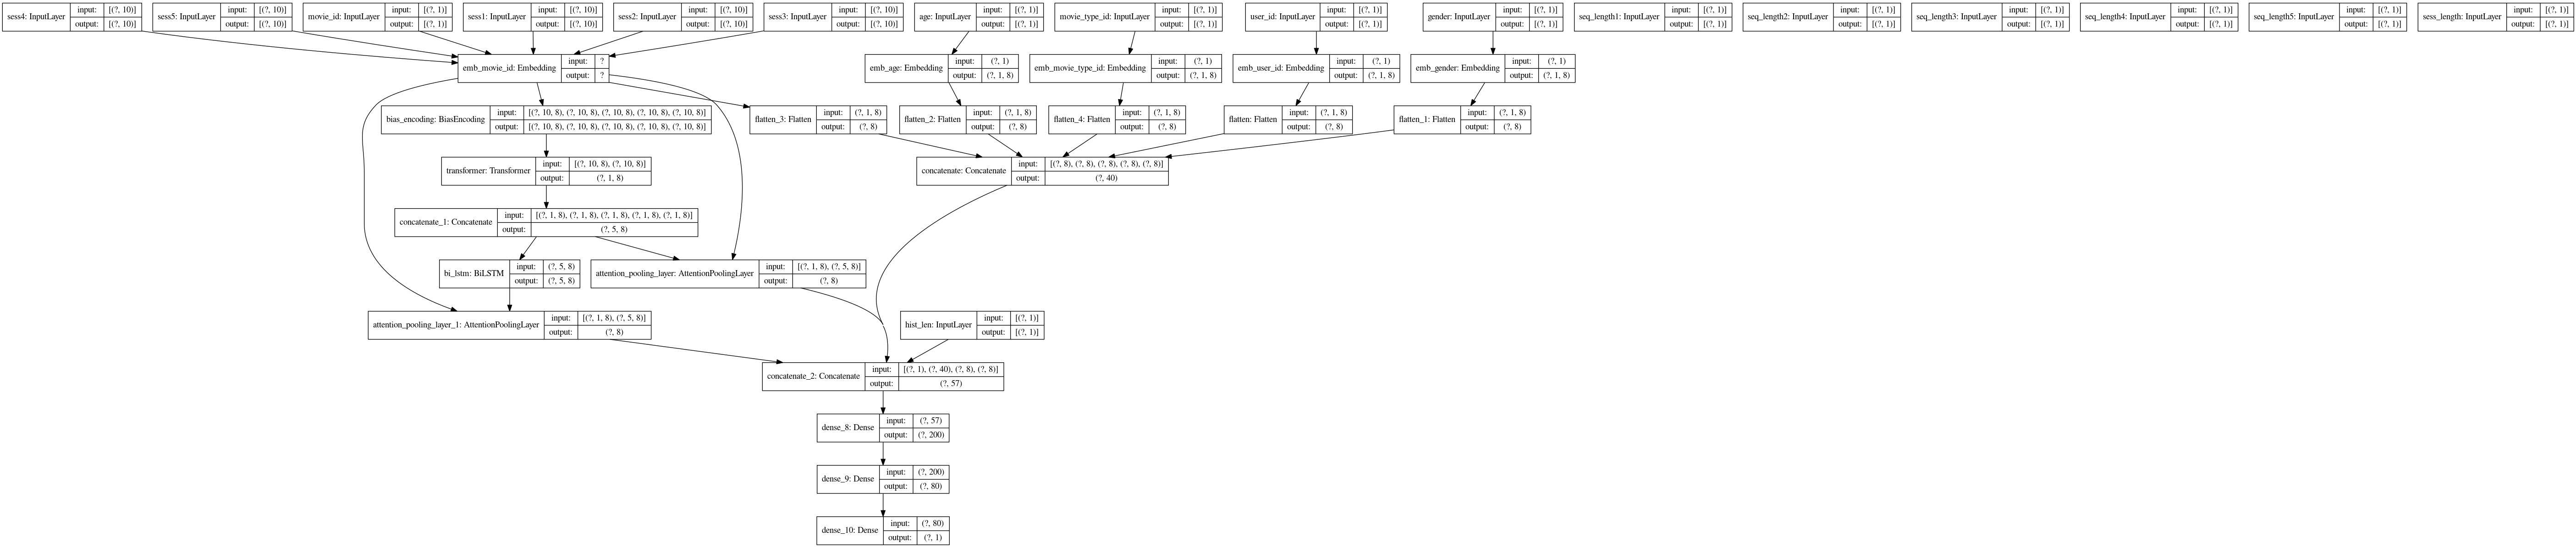

In [34]:
#模型架构可视化
from tensorflow import keras
keras.utils.plot_model(model, to_file='./DSIN.png', show_shapes=True)